In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. GETTING DATA

Dataset includes:

* `x` : training data (all are normal samples)
* `tx` : test data samples (some normal, some abnormal)
* `ty` : tells you which are normal and which are not.
  * our autoencoder would reconstruct every sample with
ty=0 very well, and make mistakes when ty=1

In [2]:
# This code allows us to upload data from local drive
from google.colab import files
uploaded = files.upload()

Saving cardio.npz to cardio.npz


In [3]:
data = np.load('cardio.npz')

In [4]:
X_train = data['x']
X_test = data['tx']
y_test= data['ty']

In [5]:
X_train

array([[ 1.69798491, -0.91998844, -0.20364049, ...,  1.67981029,
        -0.69058975, -0.49329397],
       [ 0.85144861, -0.91998844, -0.20364049, ...,  0.57633422,
        -0.62378908, -0.49329397],
       [-2.11142843, -0.18061463, -0.20364049, ..., -1.56165067,
        -0.59038875, -2.12660547],
       ...,
       [ 1.27471676, -0.91998844, -0.20364049, ...,  0.85220324,
        -0.62378908,  1.14001753],
       [ 1.27471676,  1.71403076, -0.04677629, ...,  1.26600677,
        -0.49018775,  1.14001753],
       [ 0.5339975 ,  1.17365699, -0.18424532, ...,  0.99013775,
         1.1464286 ,  1.14001753]])

In [6]:
X_train.shape

(1479, 21)

In [7]:
X_test.shape

(352, 21)

In [8]:
X_train.min()

-3.0048923462960526

In [9]:
X_train.max()

14.025335380634532

# 2. Feature scaling
- Using MinMaxScaler() in Scikit-learn to scale data

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train.copy())
X_test_scaled = scaler.transform(X_test.copy())

# 3. Create Autoencoder Model

In [11]:
# Create a model by subclassing Model class in tensorflow
class AutoencoderV2(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(4, activation='relu')
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(8, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

## 3.a. Training model using the loss function `Mean Square Error`:

Pros of mse:
  * MSE penalises the model for having huge errors by squaring them.
  * It is particularly helpful in weeding out outliers with large errors from the model by putting more weight on them.

**source:** https://medium.com/analytics-vidhya/loss-functions-to-evaluate-regression-models-8dac47e327e2

In [12]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
autoencoder = AutoencoderV2(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
history= autoencoder.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/50
12/12 [==============================] - 5s 60ms/step - loss: 0.1176 - mse: 0.1176 - val_loss: 0.1341 - val_mse: 0.1341
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.1149 - mse: 0.1149 - val_loss: 0.1314 - val_mse: 0.1314
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.1110 - mse: 0.1110 - val_loss: 0.1269 - val_mse: 0.1269
Epoch 4/50
12/12 [==============================] - 0s 22ms/step - loss: 0.1041 - mse: 0.1041 - val_loss: 0.1181 - val_mse: 0.1181
Epoch 5/50
12/12 [==============================] - 0s 15ms/step - loss: 0.0894 - mse: 0.0894 - val_loss: 0.0991 - val_mse: 0.0991
Epoch 6/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0797 - val_mse: 0.0797
Epoch 7/50
12/12 [==============================] - 0s 16ms/step - loss: 0.0470 - mse: 0.0470 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 8/50
12/12 [==============================] - 0s 20ms/step - loss: 0.0381 - ms

## 3.b. Function to measure the performance of model in detecting outlier

https://stackoverflow.com/questions/65398299/proper-inputs-for-scikit-learn-roc-auc-score-and-roc-plot

In [13]:
def performance(model, X_test, plot = True):
  """
  Measure performance of trained model mit AUC score using built-in function in sklearn

  Arguments:
    model -- trained model
    X_test -- data which are used to test the trained model
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    AUC -- the AUC score
    ROC curve
  """

  # getting predictions (recontructions) of the test data
  preds = model.predict(X_test)
  # calculate the difference between predictions and test data using mean square error
  pred_errors = tf.keras.losses.mse(preds, X_test)
  # Check the prediction performance
  auc_score = roc_auc_score(y_test, pred_errors)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    preds = model.predict(X_test)
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, pred_errors)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

11/11 [==============================] - 0s 2ms/step


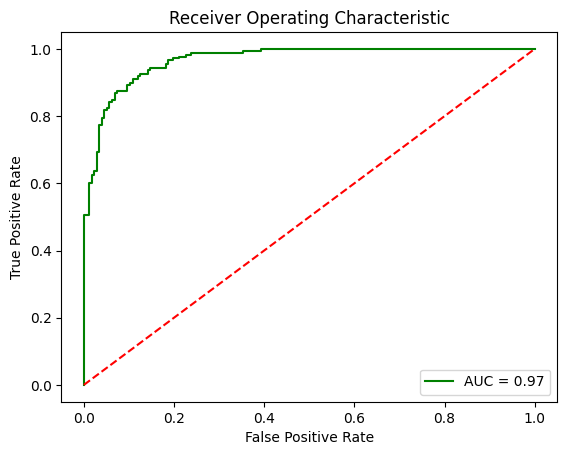

In [14]:
performance(autoencoder, X_test_scaled)

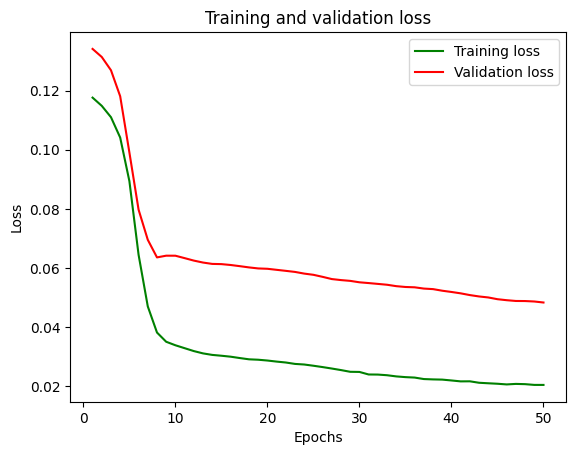

In [15]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3.c. Training a model using the loss function `Huber`

Pros of Huber:

* It is differentiable at zero.
* Outliers are handled properly due to the linearity above delta.
* The hyperparameter, 𝛿 can be tuned to maximize model accuracy.

https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber

In [16]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
autoencoder_v2 = AutoencoderV2(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
autoencoder_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=tf.keras.losses.Huber(),  
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
history_v2= autoencoder_v2.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/50
12/12 [==============================] - 2s 17ms/step - loss: 0.0588 - mse: 0.1176 - val_loss: 0.0671 - val_mse: 0.1341
Epoch 2/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0574 - mse: 0.1149 - val_loss: 0.0657 - val_mse: 0.1314
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0555 - mse: 0.1111 - val_loss: 0.0635 - val_mse: 0.1270
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0522 - mse: 0.1044 - val_loss: 0.0593 - val_mse: 0.1186
Epoch 5/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0451 - mse: 0.0903 - val_loss: 0.0501 - val_mse: 0.1002
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0328 - mse: 0.0655 - val_loss: 0.0399 - val_mse: 0.0800
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0237 - mse: 0.0474 - val_loss: 0.0348 - val_mse: 0.0700
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0192 - mse: 0.0

11/11 [==============================] - 0s 1ms/step


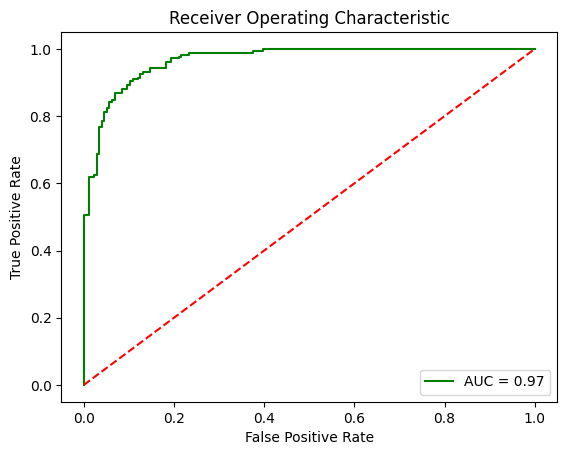

In [17]:
performance(autoencoder_v2, X_test_scaled)

# 4. Test new architecture of model

In [18]:
# Create a model by subclassing Model class in tensorflow
class AutoencoderV3(Model):
  """
  An autoencoder with Encoder and decoder blocks
  
  Arguments:
    input_dim -- number of NN units at layer 0 (input)
         
  Returns: 
    autoencoder -- autoencoder Model
  """

  def __init__(self, input_dim):
    super().__init__()
    # encoder block
    self.encoder = Sequential([
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(8, activation='relu'),
    ])
    # Decoder block
    self.decoder = Sequential([
        Dense(16, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(input_dim, activation='sigmoid')
    ])

  def call(self, inputs):
    encode = self.encoder(inputs)
    decode = self.decoder(encode)
    return decode

In [19]:
# Set random seed
tf.keras.utils.set_random_seed(42)

# Create autoencoder model
model_v1 = AutoencoderV3(input_dim=X_train_scaled.shape[1])

# Loss and optimizer definition
model_v1.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='mse',  #  Computes the mean squared logarithmic error between y_true & y_pred.
                    metrics=['mse']) 

# Training model
EPOCHS = 50
BATCH_SIZE = 128

# Fit the autoencoder
history_v3 = model_v1.fit(x=X_train_scaled, 
                          y=X_train_scaled,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=(X_test_scaled, X_test_scaled),
                          shuffle=True)

Epoch 1/50
12/12 [==============================] - 1s 15ms/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.1299 - val_mse: 0.1299
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.1085 - mse: 0.1085 - val_loss: 0.1189 - val_mse: 0.1189
Epoch 3/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0943 - mse: 0.0943 - val_loss: 0.1007 - val_mse: 0.1007
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0715 - mse: 0.0715 - val_loss: 0.0805 - val_mse: 0.0805
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 0.0493 - mse: 0.0493 - val_loss: 0.0690 - val_mse: 0.0690
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0645 - val_mse: 0.0645
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0358 - mse: 0.0358 - val_loss: 0.0635 - val_mse: 0.0635
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0345 - mse: 0.0

11/11 [==============================] - 0s 1ms/step


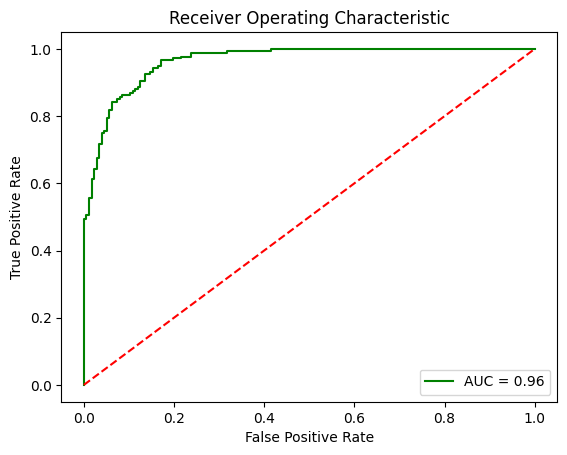

In [20]:
performance(model_v1, X_test_scaled)

# 5. Save and load the best model

- the best model here is `autoencoder` with AUC = 97%

In [21]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
autoencoder.save('saved_model/my_model')

In [22]:
# Reload the saved model
new_model = tf.keras.models.load_model('saved_model/my_model')

# 6. Ensemble Model

Build not only a single autoencoder, but an ensemble of them: 

  * first build multiple autoencoder (in a loop)
  * then average their anomaly scores (first calculate the difference between inputs and theirs predictions, then average it)
  * Calculate the final auc score

Then create a plot, showing how this final auc score depends on the
number of models used.


*Example for using tf.math.reduce_mean()*: https://i0.wp.com/www.datasciencelearner.com/wp-content/uploads/2021/08/Mean-of-tensor-of-Multi-dimensional-row-wise.jpg?ssl=1

In [23]:
def ensemble_model(model_architecture, seed_list, X_train, X_test, y_test, plot=True):
  """
  Create an ensemble model, which use an unique architecture, but with different numbers of random seed. 
  By setting a different random seed, we get a new model with the same architecture

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    seed_list -- a list of numbers which are used to set random seed for the model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
    plot -- True: plot the ROC curve. False: does not plot the ROC curve
         
  Returns: 
    avg_preds -- the average of predictions errors (the difference between inputs and their predictions) of all models in ensemble model
    auc_score -- the AUC score of ensemble model
    ROC curve
  """

  # list of pred_errors. Each element contains all the difference between inputs and their predictions of one model
  pred_errors_list = []

  for SEED in seed_list:
    # Set random seed
    tf.keras.utils.set_random_seed(SEED)

    # Create autoencoder model
    autoencoder = model_architecture(input_dim=X_train.shape[1])

    # Loss and optimizer definition
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(),
                        loss='mse',  #  Computes the mean of squares of errors between y_true & y_pred.
                        metrics=['mse']) 

    # Training model
    EPOCHS = 50
    BATCH_SIZE = 128

    # Fit the autoencoder
    history= autoencoder.fit(x=X_train, 
                              y=X_train,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_data=(X_test, X_test),
                              verbose=0,
                              shuffle=True)
    
    # getting predictions (recontructions) of the test data
    preds = autoencoder.predict(X_test)
    # calculate the difference between preds and test data using mean square error
    pred_errors = tf.keras.losses.mse(preds, X_test)
    # append pred_error to the pred_errors_list
    pred_errors_list.append(pred_errors)
  
  # convert pred_errors_list to a tensor
  preds_tensor = tf.convert_to_tensor(pred_errors_list)
  # calculate the average of all pred_errors in the pred_errors_list. We set axis=0, so that the average is calculated by row-weise. 
  avg_preds = tf.math.reduce_mean(preds_tensor, axis=0)
  # AUC score of the average pred_errors of all models vs. y_test
  auc_score = roc_auc_score(y_test, avg_preds)
  if not plot:
    print(f"AUC score: {auc_score}")
  else:
    preds = autoencoder.predict(X_test)
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, threshold = roc_curve(y_test, avg_preds)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
  
  return auc_score, avg_preds


11/11 [==============================] - 0s 1ms/step


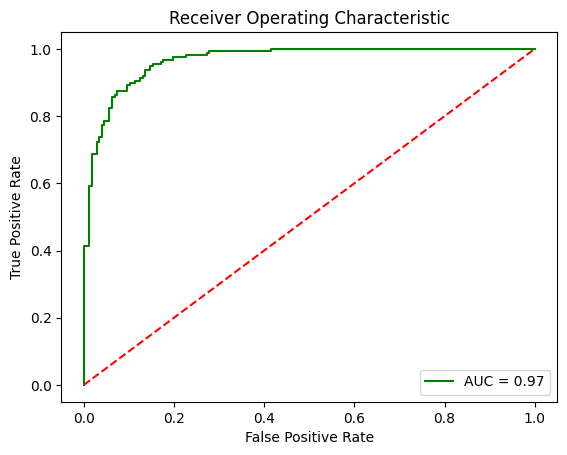

In [24]:
# Initializing a list of SEED 
SEED_LIST = [i for i in range(6, 12)]

auc_score, avg_preds = ensemble_model(AutoencoderV2, SEED_LIST, X_train_scaled, X_test_scaled, y_test, plot=True)

In [31]:
def plot_auc_models(model_architecture, num_models_list, X_train, X_test, y_test):
  """
  create a plot, showing how this final auc score of ensemble model depends on the number of models used.

  Arguments:
    model_architecture -- architecture of model, which is used to train model
    num_models_list -- a list contains the number of models which are integrated in one ensemble model
    X_train -- data which are used to train the model
    X_test -- data which are used to test the trained model
    y_test -- true labels of X_test
         
  Returns: 
    ROC curve
  """

  # list of auc score corresponding with the number of models integrated in an ensemble model
  AUC_LIST = []

  for i in num_models_list:
    # Create a random list of seed
    seed_list = np.random.randint(10, size=i).tolist()
    # Get the auc_score of the ensemble model which is trained by using seed_list
    auc_score, avg_preds = ensemble_model(model_architecture, seed_list, X_train, X_test, y_test, plot=False)
    AUC_LIST.append(np.round(auc_score, 3))

  # the plot display the correlation between auc score and the number of models integrated in an ensemble model
  plt.plot(num_models_list, AUC_LIST, 'g')
  plt.title('Correlation between AUC score and the number of autoencoders in an ensemble model')
  plt.xlabel('the number of autoencoders in an ensemble model')
  plt.ylabel('AUC score of ensembel models')
  plt.show()


11/11 [==============================] - 0s 3ms/step
AUC score: 0.9654248450413223
11/11 [==============================] - 0s 2ms/step
AUC score: 0.9654894111570248
11/11 [==============================] - 0s 1ms/step
AUC score: 0.9656831095041322
11/11 [==============================] - 0s 1ms/step
AUC score: 0.9640689566115702


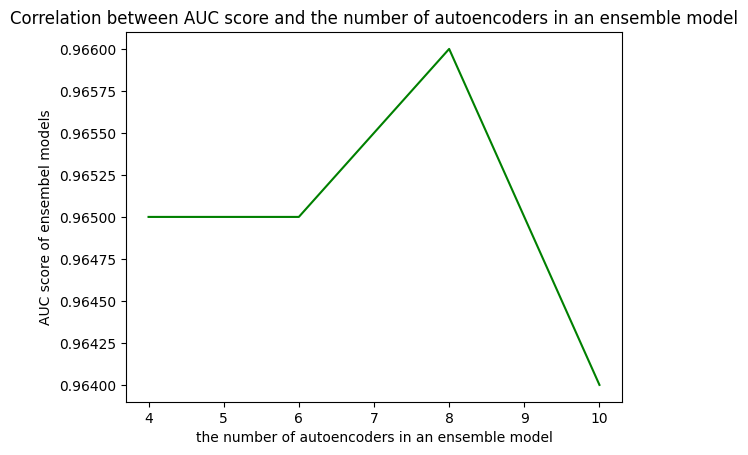

In [32]:
np.random.seed(0)
plot_auc_models(AutoencoderV2, [4, 6, 8, 10], X_train_scaled, X_test_scaled, y_test)

# All below stuffs are the old version

# 4. Finding a threshold

Figuring out a threshold which will be used to determine whether a prediction is normal or abnormal

?? Finding more methods to determine a threshold

In [27]:
def get_threshold(model, X_train):
  """
  Determine a threshold for anomalies
  
  Arguments:
    model -- trained model
    X_train -- input data which was used to train the model
         
  Returns: 
    threshold -- any mean square error value between (prediction and true value) bigger than threshold is anomalies
  """
  # getting predictions (recontructions) of the input data
  preds = model.predict(X_train)
  # calculate the difference between predictions and input data using mean square error
  pred_errors = tf.keras.losses.mse(preds, X_train)
  # Calculate threshold for anomalies
  threshold = np.mean(pred_errors.numpy()) + np.std(pred_errors.numpy()) 
  return threshold


# 5. Classifying predictions into classes:

* 0: normal sample
* 1: anomaly


In [28]:
def get_predictions(model, X_test, threshold):
  """
  Get all predictions of samples
  
  Arguments:
    model -- trained model
    X_test -- samples, which should be predicted by the trained model
    threshold -- value to determine a prediction is anomaly or not
         
  Returns: 
    y_preds -- predicted labels of each sample (0: normal, 1: abnormal)
  """
  pred = model.predict(X_test)
  pred_errors = tf.keras.losses.mse(pred, X_test)
  y_preds = [0 if i < threshold else 1 for i in pred_errors]
  return y_preds



# 6. Autoencoder Anomaly Detection Performance

In [29]:
threshold = get_threshold(autoencoder, X_train_scaled)
print(f"Thrshold: {threshold}")

# get predictions of X_test_scaled
y_preds = get_predictions(autoencoder, X_test_scaled, threshold)

# Check the prediction performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_preds))

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_preds)
print(f"AUC: {auc_score}")

47/47 [==============================] - 0s 927us/step
Thrshold: 0.029209767556762502
11/11 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       176
           1       0.84      0.95      0.89       176

    accuracy                           0.88       352
   macro avg       0.89      0.88      0.88       352
weighted avg       0.89      0.88      0.88       352

AUC: 0.8835227272727271


In [30]:
# the above code block can be write in a function
def performance_old(model, X_train, X_test):
  threshold = get_threshold(model, X_train)
  print(f"Threshold: {threshold}")

  # get predictions of X_test_scaled
  y_preds = get_predictions(model, X_test, threshold)

  # Check the prediction performance
  print(classification_report(y_test, y_preds))
  auc_score = roc_auc_score(y_test, y_preds)
  print(f"AUC: {auc_score}")